<a href="https://colab.research.google.com/github/jaaansky/multinivel/blob/master/Precio_frutas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicción en frutas y verduras en la India (2001-2008)**
![**Universidad de Chile, Facultad de Ciencias Sociales**](https://identidadcolectiva.es/victimas-desapariciones/wp-content/uploads/2016/10/descarga.png)

**Curso:** Ciencia de datos.<br>
**Año:** Segundo semestre, 2020.<br>
**Profesor:** Patricio Fernández.<br>
**Ayudante:** Alexis Villanueva. <br>
**Integrantes:** Sebastián Cortinez, Jan Dimter, Javiera Urrutia.<br>

### **0. Objetivo**
El programa de alimentación para jardines infantiles indio solicitó a estudiantes de sociología versados en ciencia de datos la tarea de generar un modelo de predicción para los productos de consumo básico contenidos en su registro de compra. Se quiere generar un plan de alimentación para el 2019 cuyo presupuesto (generado en febrero del 2018) sufra lo menos posible el efecto de la inflación. Por lo tanto, a partir de la construcción de un modelo de machine learning que prediga los valores promedio anuales 2019 de cada producto se buscará responder a la pregunta ¿qué productos son más suceptibles de sufrir un alza en sus precios el año 2019 respecto a los precios del 2018? Para la construcción del modelo se utilizarán los datos históricos registrados desde enero del 2011 hasta febrero del 2018.

A continuación, crearemos el modelo de predicción.


### **1. Instalación de paquetes**
Utilizaremos el paquete Pandas. Este nos permite almacenar los datos importados, haciendo posible el proceso de lectura, limpieza y análisis de los datos. 
Abreviaremos el paquete como "as" para hacer más rápido su uso a lo largo del desarrollo.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 150
import seaborn as sns
from sklearn.model_selection import train_test_split # Para separar a data
from sklearn                 import metrics # Métricas de desempeño de los modelos
from sklearn.metrics         import mean_squared_error
from sklearn                 import tree #Algoritmo Decision Tree
from sklearn.tree            import DecisionTreeRegressor
from sklearn.ensemble        import RandomForestRegressor
from joblib                  import dump, load
from IPython.display         import display, HTML, Image

### **2. Carga de base de datos**
Para este trabajo utilizaremos la base de datos sobre valores diarios de frutas y verduras entre 2011 y 2018 en la India. Si bien identificamos la fuente la base de datos subida por RaghuReddy en [Kaggle](https://www.kaggle.com/raghu07/vegetable-and-fruits-price-in-india), utilizaremos la versión disponible en el curso (consistente en dos archivos). Para la carga hemos subido los archivos a un servidor, facilitando el proceso. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
url1 = '/content/drive/My Drive/train1.csv'
url2 = "/content/drive/My Drive/train2.csv"
train1 = pd.read_csv(url1,sep=",", encoding='UTF-8', low_memory=False)
train2 = pd.read_csv(url2,sep=",", encoding='UTF-8', low_memory=False)


## **3. Exploración de estructura**


Revisamos la estructura de las bases, encontrándonos en ambos casos con 5 variables por database. Para **train1** son: *Unnamed*, *datesk*, *Item Name*, *price*, e *id*. En el caso de **train2** estas son: *Unnamed: 0*, *datesk*, *Item Name*, *Date*, e *id*, es decir, las mismas reemplazando price (precio) por date (fecha). Además, cada base de datos tiene 868965 filas. Estas similitudes nos dan pistas sobre la posibilidad de que ambos datasets respondan a los mismos casos, sin embargo, esto requerirá ser puesto en evaluación.

In [5]:
#Estructura de la base train1
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868965 entries, 0 to 868964
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  868965 non-null  int64  
 1   datesk      868965 non-null  int64  
 2   Item Name   861126 non-null  object 
 3   price       551948 non-null  float64
 4   id          868965 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 33.1+ MB


In [ ]:
train2.info()

Revisamos la estructura de las bases a partir de las 5 primeras y 5 últimas filas:

In [ ]:
print("Estructura train1")
train1

In [ ]:
print("Estructura train2")
train2

Asignaremos a la primera columna de ambos datasets (*Unnamed: 0*) el nombre de "*V1*". Además, reordenaremos las columnas según su contenido.

In [6]:
#Rename de la variable
train1 = train1.rename(columns = {"Unnamed: 0": "V1"}) 
train2 = train2.rename(columns = {"Unnamed: 0": "V1"}) 
#Creación nuevos índices
indice1 = ['id','V1', 'datesk','Item Name', 'price']
indice2 = ['id','V1', 'datesk', 'Date','Item Name']
#Nuevo orden para los datasets
train1 = train1[indice1]
train2 = train2[indice2]

Observamos que en estas primeras 5 filas las variables *id* y *V1* toman los mismos valores, por lo que testearemos si existen valores distintos para cada caso. De existir, el valor sería superior a 0.

In [ ]:
print("Para train1")
print(sum(train1['id']!=train1['V1']))
print("Para train2")
print(sum(train2['id']!=train2['V1']))

Por lo tanto, concluimos que id y V1 son idénticas entre ellas en ambas bases, no aportando información nueva una de otra. Eliminaremos V1, manteniendo id, en ambos datasets.

In [ ]:
train1.drop(columns=['V1'])
train2.drop(columns=['V1'])

A continuación revisaremos la posibilidad de combinar ambos datasets debido a sus similitudes. Para esto realizaremos test revisando si las variables de ambos son idénticas o no. Si existen casos divergentes el valor superará a 0 para cada variable.

In [ ]:
print("Cantidad de valores divergentes para id entre ambos datasets")
print(sum(train1['id']!=train2['id']))
print("Cantidad de valores divergentes para Item Name entre ambos datasets")
print(sum(train1['Item Name']!=train2['Item Name']))
print("Cantidad de valores divergentes para datesk entre ambos datasets")
print(sum(train1['datesk']!=train2['datesk']))

Existen divergencias para la columna de Item Name, pero es posible que estas sean valores NA's, lo testearemos a continuación:

In [ ]:
print("Valores nulos para Item Name en train1")
display(train1["Item Name"].isnull().sum())
print("Valores nulos para Item Name en train2")
display(train2["Item Name"].isnull().sum())

El número de NA's en esta variable resulta idéntico. Testearemos si corresponden a casos con igual índice, sumando 0 en caso de que se correspondan todos.

In [ ]:
indexNA_IN_train1 = train1["Item Name"].isnull().index
indexNA_IN_train2 = train2["Item Name"].isnull().index
print(sum(indexNA_IN_train1 != indexNA_IN_train2))

### **3.1 Merge**
Tras estos análisis nos encontramos en condiciones de afirmar que es posible unir los datasets pues aquellas columnas que mantienen idéntico nombre son idénticas en contenido. La forma de unión será a través de *merge* y no *concat* pues no representan casos nuevos, sino que información (variables) nueva sobre los mismos casos.

In [9]:
#Merge de los datasets
train = pd.merge(train1,train2,on=['id','Item Name','datesk'])
#Orden para los datasets
indice3 = ['id', 'datesk', 'Date','Item Name','price']
train = train[indice3]

In [ ]:
#Revisamos la base
train

id    datesk                 Date          Item Name  price
0            0  20110101  2011-01-01 00:00:00     Kashini greens    NaN
1            1  20110101  2011-01-01 00:00:00    Pineapple juice    NaN
2            2  20110101  2011-01-01 00:00:00      Thiland Juice    NaN
3            3  20110101  2011-01-01 00:00:00      Thiland Jelly    NaN
4            4  20110101  2011-01-01 00:00:00       Orange juice    NaN
...        ...       ...                  ...                ...    ...
868960  868960  20180227           27/02/2018       Komark fruit   28.0
868961  868961  20180227           27/02/2018          Dry dates   20.0
868962  868962  20180227           27/02/2018  Tamarind seedless  230.0
868963  868963  20180227           27/02/2018    Dry fruit mixed    NaN
868964  868964  20180227           27/02/2018  Tender Coconut(S)   25.0

[868965 rows x 5 columns]

### **3.2 Análisis casos duplicados**
En primer lugar, analizaremos la existencia de casos duplicados. En ningún caso consideraremos la variable "id" pues esta corresponde a un índice único para cada fila. Contabilizarlo implicaría obtener artificialmente 0 casos duplicados.

In [ ]:
train[['datesk','Item Name',"price","Date"]].duplicated().sum()

La cantidad de casos duplicados corresponde a 5226. Revisamos algunos casos:

In [ ]:
train[train[['datesk','Item Name',"price","Date"]].duplicated()==True]

In [ ]:
train[train[['datesk','Item Name',"price","Date"]].duplicated()].info()

Podemos observar que aquellos casos duplicados no tienen ningún valor válido para "Item Name" ni "price". En el análisis de variables se revisará cómo están distribuidos estos casos.

### **3.3 Análisis variables**


### 3.3.1 Fecha
Nos encontramos que en la base de datos existen dos variables relativas a la fecha: a) datesk y b) Date. Exploraremos a continuación las características de ambas.



*   Date



In [ ]:
#Primeros y últimos casos para Date
train['Date']

In [ ]:
#Valores únicos para la variable Date (representa la cantidad de días únicos contenidos en la base)
train["Date"].unique().shape

In [ ]:
#Revisamos frecuencias de valores para Date (representa la frecuencia de días únicos contenidos en la base)
train["Date"].value_counts()

* datesk

In [ ]:
#Primeros y últimos casos para datesk
train["datesk"]

In [ ]:
#Valores únicos para la variable datesk (representa la cantidad de días únicos contenidos en la base)
train["datesk"].unique().shape

In [ ]:
#Revisamos frecuencias de valores para datesk (representa la frecuencia de días únicos contenidos en la base)
train["datesk"].value_counts()

**Comentarios análisis variables Fecha** <br>
Dada la falta de uniformidad de formato para Date, resulta difícil realizar un análisis respecto de su distribución. Observamos que ambas variables contemplan la misma cantidad de días únicos (2613). La frecuencia de casos únicos por día varía entre 331 y 333. Asumiendo que uno de esos valores únicos en cada caso corresponde a NA, podemos decir que diariamente existen entre 330 y 332 productos en la base de datos. <br>
Dado que los valores coinciden para ambas variables, sin embargo una de ellas (Date) mantiene diferencias de formato a lo largo de toda la base de datos, resultando imposible en algunos casos tener certeza de la fecha, decidimos utilizar para los fines necesarios únicamente la variable *datesk*.

#### 3.3.1.1 Nuevas variables sobre fecha
La variable "datesk" nos entega información clave, sin embargo, esta es de clase *int64*, limitando nuestra posibilidad de análisis. Realizaremos una conversión a la clase *datetime* que nos entrega mejores posibilidades. Además, pensando en un futuro modelo de machine learning, generaremos 3 nuevas variables según el año (year), mes (month) y día (day) en particular de cada caso. Esto puede sernos de utilidad a futuro.

In [ ]:
train.info()

In [10]:
train['Dates'] = pd.to_datetime(train['datesk'],format='%Y%m%d')
train['year'] = train['Dates'].dt.year
train['month'] = train['Dates'].dt.month
train['day'] = train['Dates'].dt.day

Decidimos, además, crear una nueva variable para optimizar la visualización del modelo a construir. La nueva variable correspondería al código identificador (float) para cada fecha del dataset. Justificamos esta decisión en que esta disposición de los datos permite visualizar de manera más intuitiva los  gráficos posteriores contenidos en la sección de *Modelo Machine Learning*.

In [ ]:
#Creación de variable fecha como números continuos
train["datecode"] = train["Dates"].astype("category")
train['datecode']  = train['datecode'].cat.codes

Revisamos las nuevas variables de la base de datos, dando cuenta que se ha agregado exitosamente "*Dates*" de clase *datetime[ns]*, junto con "*year*", "*month*" y "*day*" de clase "*int64*" las tres, y *datecode* de clase *int16*.

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 868965 entries, 0 to 868964
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         868965 non-null  int64         
 1   datesk     868965 non-null  int64         
 2   Date       868965 non-null  object        
 3   Item Name  861126 non-null  category      
 4   price      551948 non-null  float64       
 5   Dates      868965 non-null  datetime64[ns]
 6   year       868965 non-null  int64         
 7   month      868965 non-null  int64         
 8   day        868965 non-null  int64         
 9   ItemCode   868965 non-null  int16         
 10  datecode   868965 non-null  int16         
dtypes: category(1), datetime64[ns](1), float64(1), int16(2), int64(5), object(1)
memory usage: 64.7+ MB


#### 3.3.1.2 Análisis de fechas faltantes

Revisaremos a continuación la distribución de las fechas de la base de datos, en contraste con las fechas reales para el mismo periodo. Partiremos identificando fecha inicial, fecha final, cantidad de días comprendidos y finalmente revisaremos fechas que no estén en el dataset.

In [ ]:
#pd.Timedelta((pd.to_datetime('2018-02-27')) - (pd.to_datetime('2011-01-01')))
pd.date_range(start = '2011-01-01', end = '2018-02-27' )

El tiempo contenido en la base de datos va desde el día 01 de enero del 2011 hasta el 27 de febrero del 2018. La cantidad de días corresponde a 2615. A continuación se testea la posible falta de días:

In [ ]:
pd.date_range(start = '2011-01-01', end = '2018-02-27' ).difference(train.Dates)

Existen dos días (1 de enero de 2014 y 1 de enero de 2017) que no están contenidos en la base de datos. Esto nos explica por qué la cantidad de valores únicos corresponde a 2613 en lugar de 2615.

#### 3.3.1.3 Casos por fecha

La cantidad de casos se distribuye de la siguiente manera:

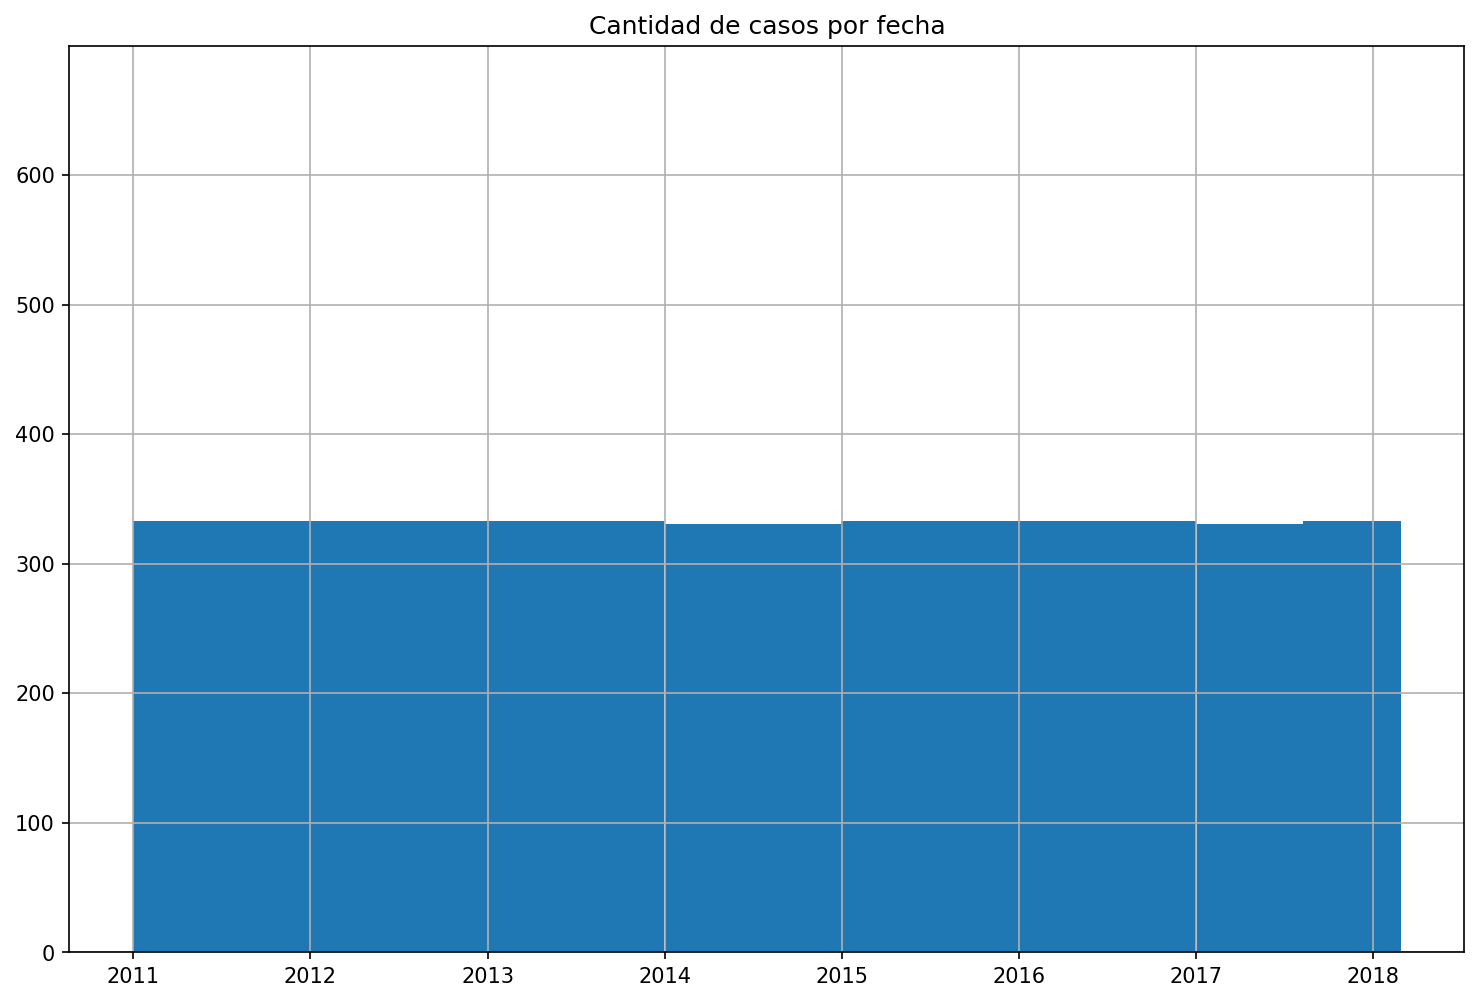

In [14]:
plt.title('Cantidad de casos por fecha')
plt.hist(train.Dates, bins = 2613)
plt.grid(True)
plt.show()

Se aprecian de forma muy clara los momentos donde existen 2 casos únicos menos, conteniendo 331 casos por día todo el año 2014 y parte del año 2017.

### 3.3.2 Item Name
*Item Name* corresponde a la variable que contiene el nombre de los productos. Como revisamos previamente, es de tipo *object*. Será convertida al tipo category pues nos permite una mejor manipulación. Además, a través de esta transformación, se creará una nueva variable conteniendo un índice numérico para cada valor único de Item Name.

In [23]:
#Transformación de Item Name a tipo category
train["Item Name"] = train["Item Name"].astype("category")
#Creación de ItemCode
train['ItemCode']  = train['Item Name'].cat.codes

Revisamos la frecuencia de sus categorías:

In [ ]:
train["Item Name"].value_counts()
#Existe una diferencia de 582 entre casos

Nos encontramos con 330 valores únicos para Item Name, donde la mayoría, excepto dos items, tienen 2613 casos cada uno (uno por cada día). Apple Simla y Apple Delicious son los dos casos que tienen 2031 casos cada uno. Esto vendría a explicar la diferencia revisada previamente en cantidad de casos por fecha.

Revisamos lo mismo, esta vez para ItemCode:

In [ ]:
train["ItemCode"].value_counts()

Nos encontramos con que esta vez surge una nueva categoría (-1) que viene a representar a aquellos casos correspondientes a NA para Item Name.

#### 3.3.2.1 Casos de Item Name NA

Analizaremos aquellos casos que en la variable Item Name contienen por valor NA. 

In [26]:
#Visualizamos aquellos casos de forma aislada
NaItemName=train[train['Item Name'].isna()==True]
NaItemName

id    datesk                 Date  ... day  ItemCode datecode
10          10  20110101  2011-01-01 00:00:00  ...   1        -1        0
11          11  20110101  2011-01-01 00:00:00  ...   1        -1        0
12          12  20110101  2011-01-01 00:00:00  ...   1        -1        0
363        363  20110102  2011-02-01 00:00:00  ...   2        -1        1
364        364  20110102  2011-02-01 00:00:00  ...   2        -1        1
...        ...       ...                  ...  ...  ..       ...      ...
868438  868438  20180226           26/02/2018  ...  26        -1     2611
868450  868450  20180226           26/02/2018  ...  26        -1     2611
868772  868772  20180227           27/02/2018  ...  27        -1     2612
868784  868784  20180227           27/02/2018  ...  27        -1     2612
868787  868787  20180227           27/02/2018  ...  27        -1     2612

[7839 rows x 11 columns]

Nos llama la atención dos cosas:
1. Aparentemente ninguno de los casos tiene valores válidos para *price*, esto es muy relevante pues, implicaría no tener forma en absoluto de distinguir estos casos de cualquier otro. A continuación se revisará si existen valores válidos para price dentro de este subset.
2. Aparentemente hay tres casos por cada fecha en que se repite este patrón de no contener valores válidos para Item Name ni para price. Correspondería así a una suerte de 3 casos "fantasma" a lo largo de todo el dataset. El hecho de que la cantidad de valores nulos para Item Name corresponda a 7839 `(868965-861126)` implica en promedio 3 casos diarios para el dataset`(7839/2613)=3`.

In [27]:
NaItemName["price"].value_counts()

Series([], Name: price, dtype: int64)

1. No se detectan valores válidos para price dentro del subset.
2. A continuación haremos un test lógico para comprobar que todos los días tienen 3 casos con Item Name *NA*. Si el resultado es 0 nuestra hipótesis es correcta.

In [28]:
sum(train["Item Name"].isnull().groupby([train['Dates']]).sum()!=3)

0

Podemos concluir como verdadera la existencia de 3 casos "fantasma", incapaces de ser identificados ni por Item Name ni por price. Al no aportar ninguna información, y no tener sentido una posible imputación (pues solo son fechas) decidimos eliminar estos casos. Procedemos a eliminar los casos:

In [29]:
train = train.dropna(subset=['Item Name'])

Revisamos nuevamente la estructura de la base de datos, habiendo realizado las modificaciones:

In [ ]:
train.info()

Y corroboramos también que la categoría (-1) de ItemCode, que representaba a los NA, ya no registra casos:

In [30]:
train["ItemCode"].value_counts()

329    2613
104    2613
106    2613
107    2613
108    2613
       ... 
223    2613
224    2613
0      2613
12     2031
5      2031
Name: ItemCode, Length: 330, dtype: int64

### 3.3.3 Precio

Partiremos con un análisis descriptivo de la variable precio (price):

In [ ]:
train.price.describe()

count    499144.000000
mean         57.130116
std          69.827559
min           0.000000
25%          14.000000
50%          34.000000
75%          75.000000
max         863.000000
Name: price, dtype: float64

Existen 551948 casos válidos, su promedio es 51,7 aprox., la desviación estándar es de 68,4 aprox., el límite del primer cuartil es 0, es decir, el 25% de los casos tienen precio igual o menor a 0 y el valor máximo es 863. Revisamos a continuación su distribución en histograma:

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


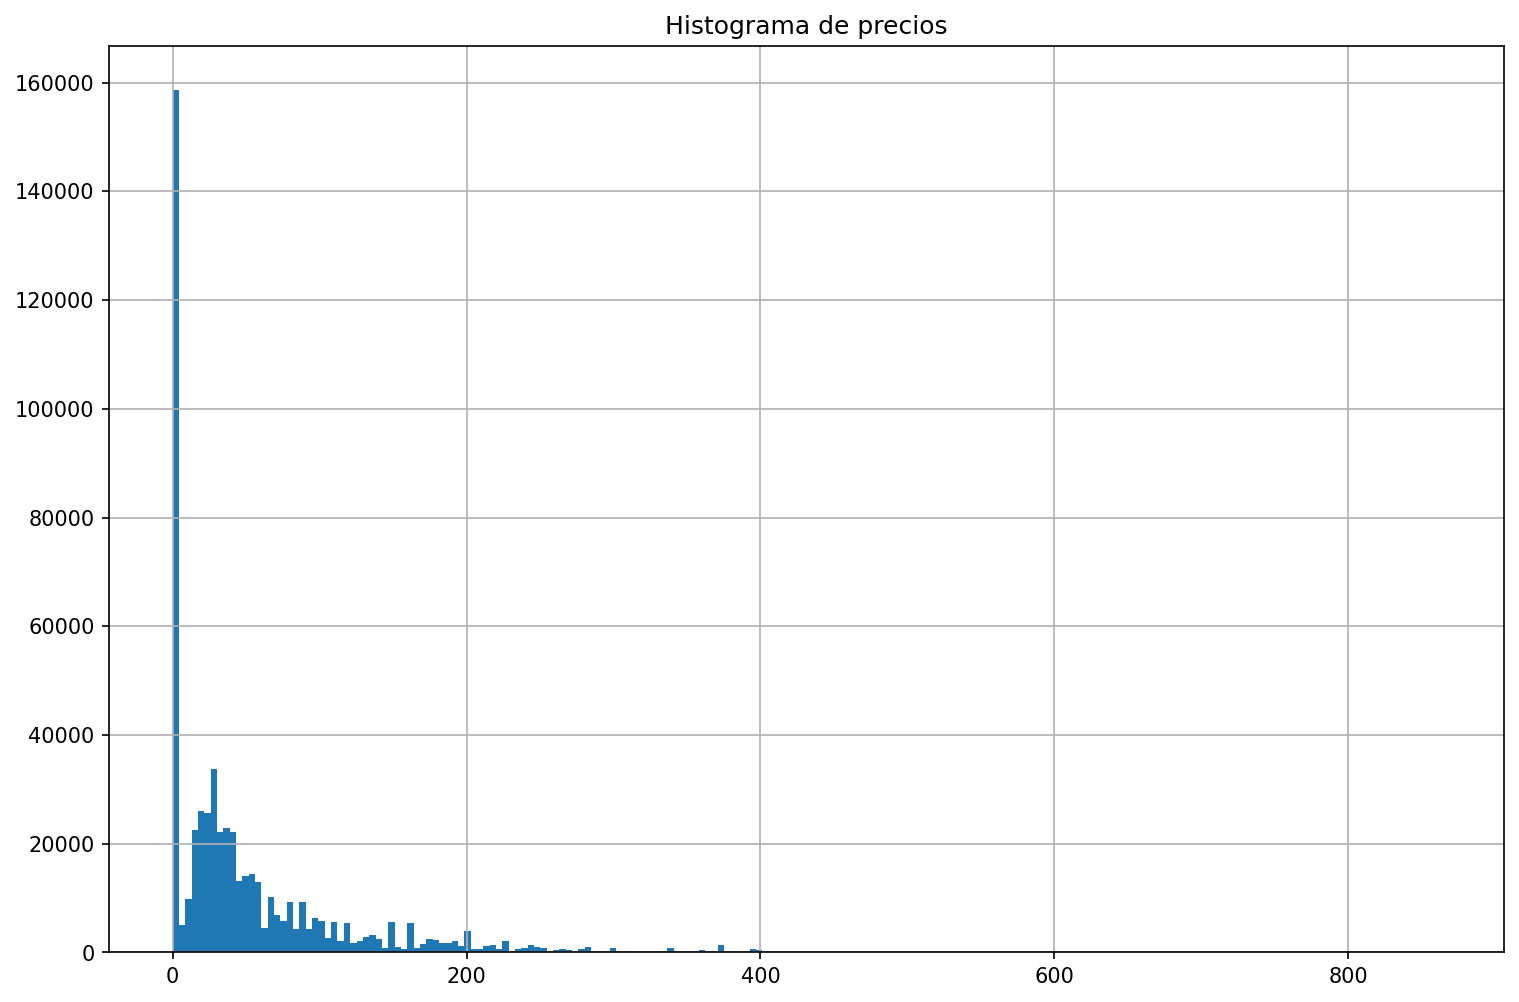

In [31]:
plt.title('Histograma de precios')
plt.hist(train.price,bins=200)
plt.grid(True)

Existe una altísima concentración de casos en 0. Revisaremos la cantidad precisa de casos que tienen este valor en su precio. Nos resulta algo muy extraño: en teoría el precio de venta de un artículo no puede ser 0. Pensamos en la posibilidad de que este valor haya sido truncado. Se analizarán estos casos a continuación:

##### 3.3.3.1 Casos con precio 0

In [32]:
train[train['price']==0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156298 entries, 22311 to 868951
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         156298 non-null  int64         
 1   datesk     156298 non-null  int64         
 2   Date       156298 non-null  object        
 3   Item Name  156298 non-null  category      
 4   price      156298 non-null  float64       
 5   Dates      156298 non-null  datetime64[ns]
 6   year       156298 non-null  int64         
 7   month      156298 non-null  int64         
 8   day        156298 non-null  int64         
 9   ItemCode   156298 non-null  int16         
 10  datecode   156298 non-null  int16         
dtypes: category(1), datetime64[ns](1), float64(1), int16(2), int64(5), object(1)
memory usage: 11.6+ MB


Observamos que la cantidad de casos cuyo precio corresponde a 0 es 156298, casi un 18% del total de la muestra. Es una cifra importante pensando en un modelo de ML. Estos casos no tienen ningún NA para sus variables, siendo plenamente identificables.

Revisamos la distribución de casos con precio 0 según fecha:

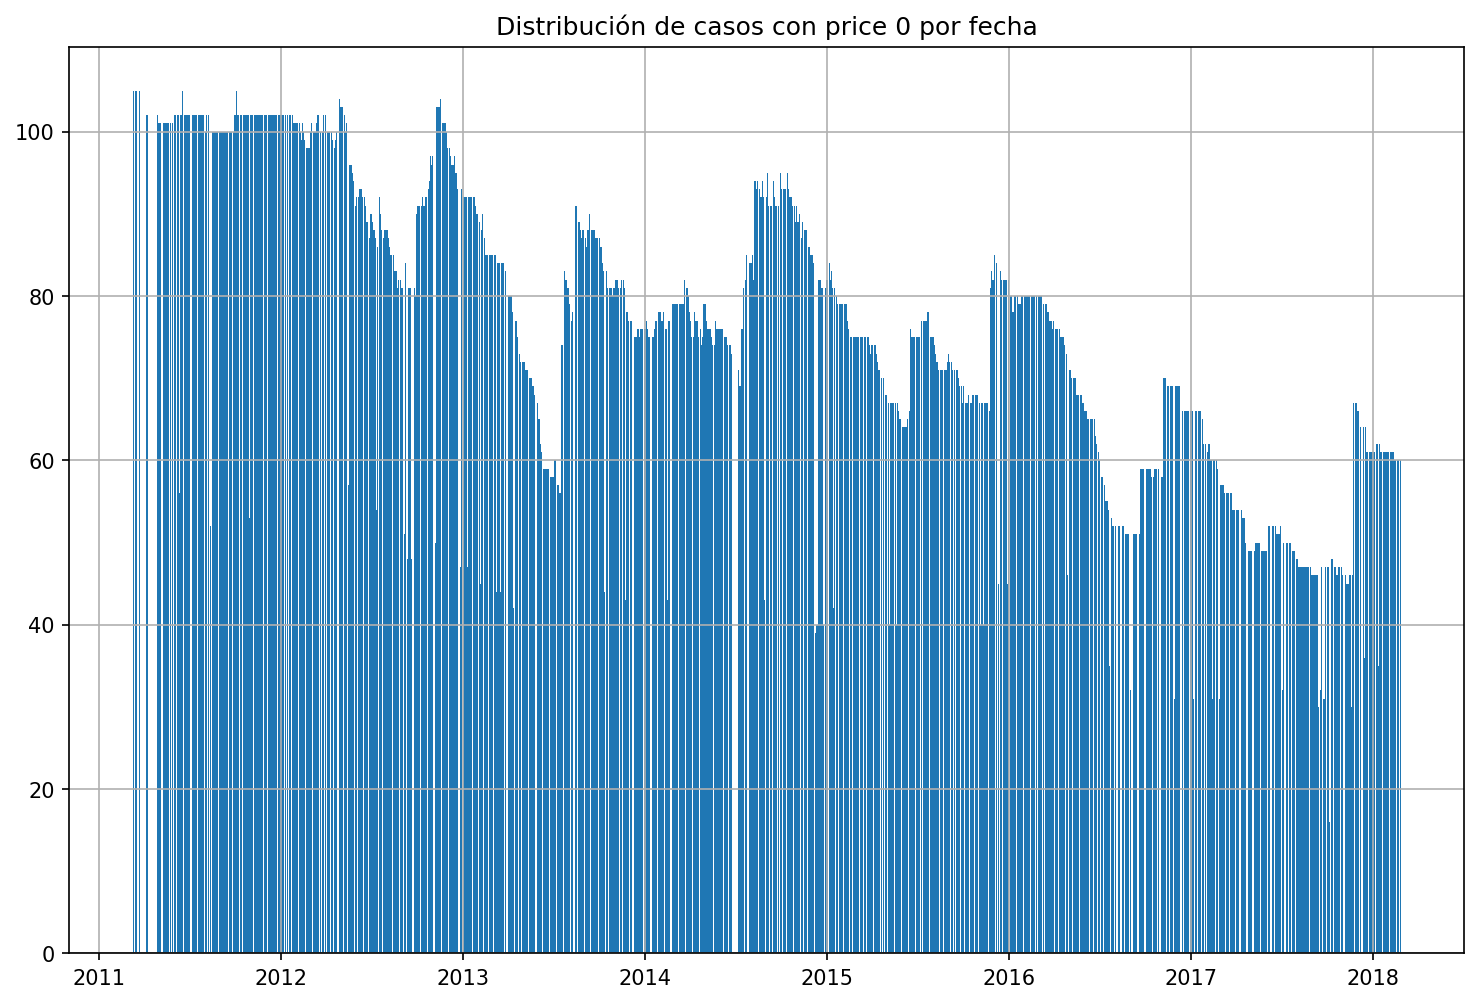

In [33]:
precio0 = train[train.price==0]
plt.title('Distribución de casos con price 0 por fecha')
plt.hist(precio0.Dates, bins = 2613)
plt.grid(True)

En búsqueda de patrones, podemos observar que el 2011 (desde que dejan de existir muchos casos NA, a mediados de año), es el año más estable en cantidad de casos con precio 0. En el resto de los años hay un patrón común: la cantidad de casos con precio 0 se incrementa en los extremos del año, existiendo en la mitad del año una disminución importante en su proporción. El 2015 sería un año particular en cuanto se registra a mediados de año un incremento importante en la cantidad de casos con valor 0 para precio.

A continuación se testea si existen días  donde todos los precios válidos (sin considerar NA) sean 0. El valor resultante corresponde a la cantidad de días donde se cumple la condición:

In [34]:
TestPrecio0 = train.dropna(subset=['price']).groupby([train['Dates']]).sum()
sum(TestPrecio0["price"]==0)


0

No existen días donde todos los precios sean 0.<br>
A continuación testearemos la posibilidad de existencia de productos cuyos precios correspondan en todos sus valores válidos a 0. Resulta complejo trabajar con valores 0. Como revisamos inflación, implicaría dividir por cero.

Sobre su posible **imputación** distinguiremos dos casos, aquellos productos en los que todos sus valores corresponden a 0, y otros que en fechas puntuales han tenido por valor 0. El segundo caso resulta bastante sencillo de imputar con un promedio de valores cercanos. En el primer caso, como no existe varianza para los valores implicaría mantenerlos como 0. Consideramos la posibilidad de imputarlos con decimales (ej. 0,1), sin embargo, bajo el supuesto de que estarían truncados, implica desconocer qué tan pequeños son. Por ejemplo, si el valor real es 0,01 imputarlo con 0,1 implicaría generar una inflación ficticia irremediable. Frente a lo anterior decidimos eliminar los productos cuyos precios válidos son todos 0. Se estima la cantidad de estos casos a continuación:

In [35]:
TestPrecio0b = train.groupby([train['Item Name']]).mean()
sum(TestPrecio0b["price"]==0)

27

Son 27 los productos que tienen por 0 el promedio de todos sus precios válidos. Frente a lo señalado previamente, procedemos a eliminarlos a continuación:

In [36]:
Cerodrop = ['Apple Premium', 'Badami', 'Banana karpura','Ber fruit/Bore fruit', 'Berry Delhi', 'Brinjal Mlore',
                  'Brinjal long', 'Capsicum 1', 'Cashew nut', 'Cauliflower(S)',
                  'Cowpea Local', 'Dates', 'Dates Arebian', 'Dates seedless',
                  'Ginger ooty', 'Grapes Dry 100gm', 'Ground nut Hybrid',
                  'Indian kinora apple', 'Kashini greens', 'Lime Bijapur',
                  'Malenian apple', 'Mushroom Milky', 'Onion pack',
                  'Pomegranate', 'Potato pack', 'Potato(S)', 'Rampal']
train=train[-train["Item Name"].isin(Cerodrop)]

##### 3.3.3.1 Casos con precio NA

Revisaremos la distribución de casos con price válido (distinto de NA) y luego la de price no válido (igual a NA):

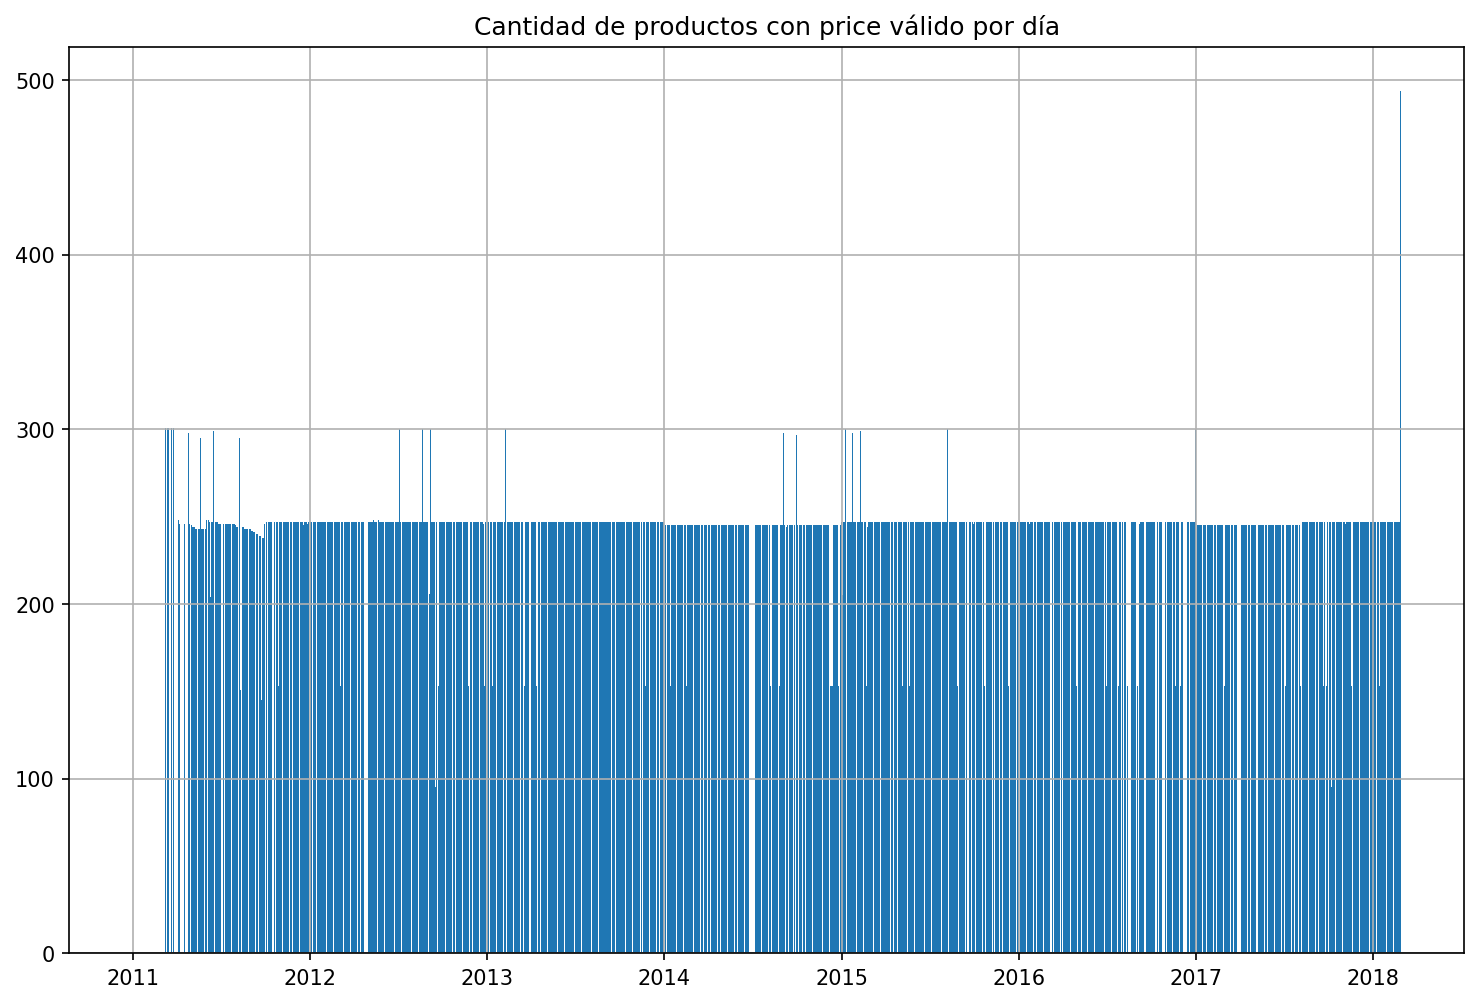

In [37]:
plt.title('Cantidad de productos con price válido por día')
plt.hist(train.dropna(subset=['price']).Dates, bins = 2613)
plt.grid(True)
plt.show()

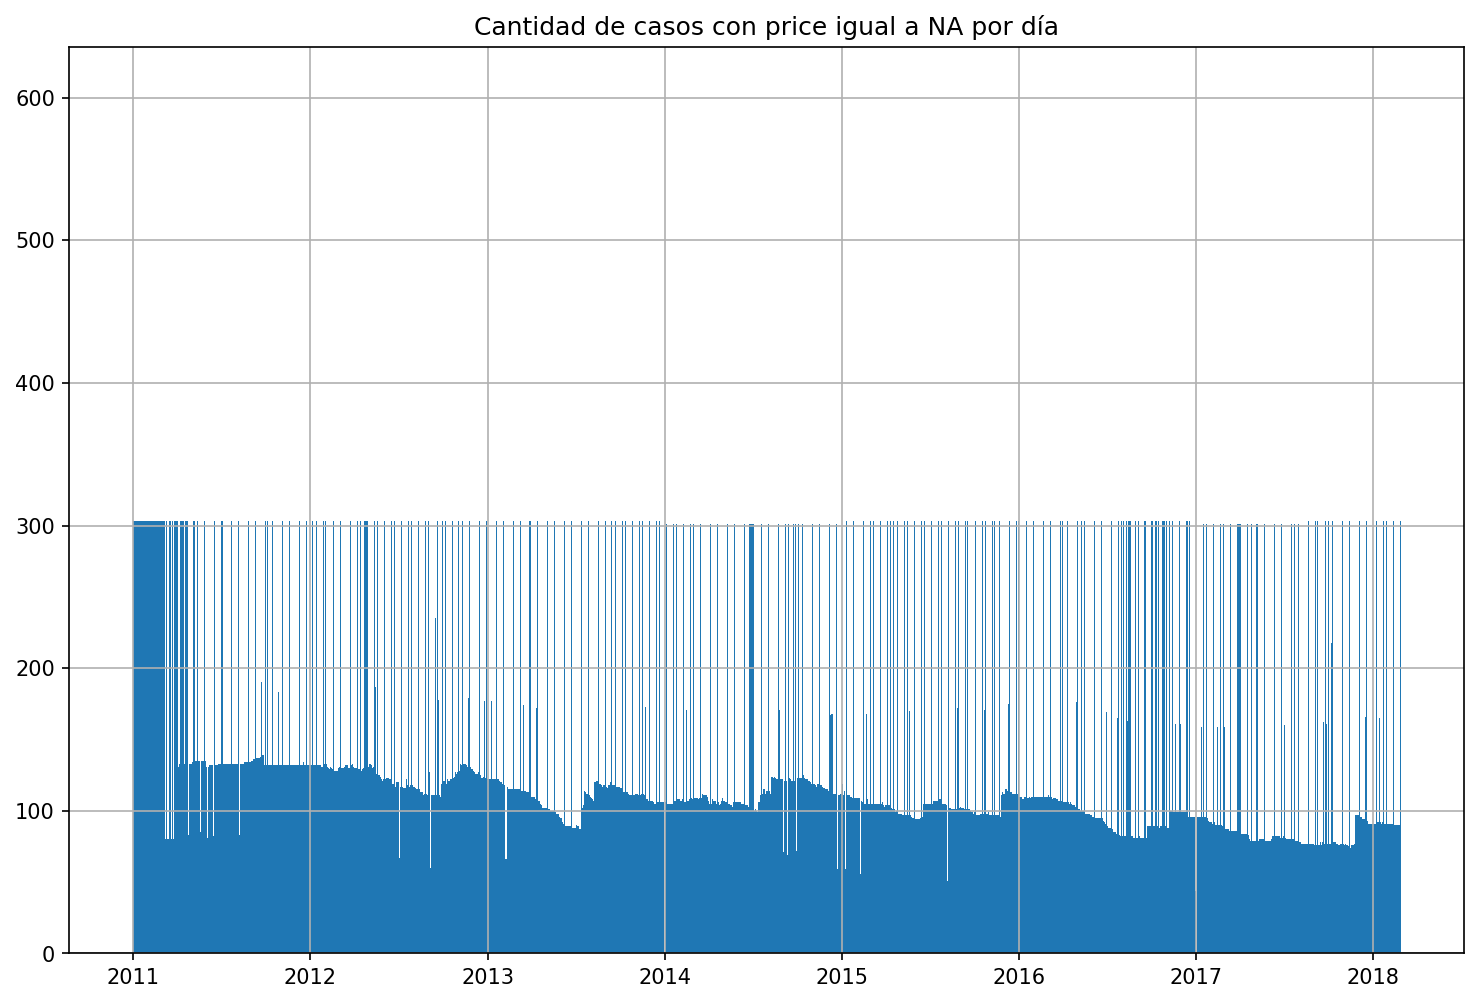

In [ ]:
PruebapreciosNA = train[train.price.isna()==True]
plt.title('Cantidad de casos con price igual a NA por día')
plt.hist(PruebapreciosNA.Dates, bins = 2613)
plt.grid(True)

Hay una alta concentración de días a comienzos del 2011 donde (aparentemente) por meses no hay casos que tengan valores de price válidos. 

A continuación transformaremos los valores 0 restantes como NA para su futura imputación:

In [38]:
train['price'] = train['price'].replace(0,np.nan)

Verificamos la nueva cantidad de precios 0:

In [39]:
sum(train["price"]==0)

0

##4.Imputación

Dado que para una imputación nos parece necesario representar forma óptima la diversidad de valores (price) para cada producto, procuraremos imputar los valores NA con el promedio mensual para cada año en específico. Sin embargo, ocurre que hay productos que en un mes particular no tuvieron casos superiores a 0, siendo necesario recurrir a la imputación, por año, por mes (independiente del año) y finalmente para casos que no logren ninguna de las 3 imputaciones anteriores, por su promedio histórico.

In [40]:
train['priceimp'] = train['price'].fillna(train.groupby(['Item Name','month','year'])['price'].transform('mean'))
train['priceimp'] = train['priceimp'].fillna(train.groupby(['Item Name','year'])['price'].transform('mean'))
train['priceimp'] = train['priceimp'].fillna(train.groupby(['Item Name','month'])['price'].transform('mean'))
train['priceimp'] = train['priceimp'].fillna(train.groupby(['Item Name'])['price'].transform('mean'))

Testeamos la cantidad de de valores en *price* NA:

In [ ]:
train.priceimp.isnull().sum()

0

##5.Modelos de ML

En esta sección desarrollaremos el modelo de regresión para precios en técnicas de Machine Learning. Desarrollaremos 3 modelos, uno a través de Data Trees, otro a través de Random Forest y el último a través de XGBoost. Partiremos creando las muestras de entrenamiento y testeo, para luego adentrarnos en el desarrollo del modelo.

In [42]:
# Borramos todos las columnas que no vamos usar en el aprendizaje automático.
objects = ['id','Dates','datesk','price','Date','year','month','day','Item Name','priceimp']
X = train.drop(columns=objects)
#Asignamos priceimp como variable dependiente
Y = train['priceimp']
#Creamos las muestras respectivas
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 111)

Revisamos las variables usadas como features:

In [43]:
X.columns

Index(['ItemCode', 'datecode'], dtype='object')

Desarrollamos el modelo:

In [44]:
# Decision Tree
dTree = tree.DecisionTreeRegressor(criterion = 'mse', random_state = 111)  
dTree.fit(X_train, Y_train)

Y_pred_tree = dTree.predict(X_test)

In [45]:
real_pred = pd.concat([Y_test.reset_index(drop=True),pd.DataFrame(Y_pred_tree)],axis=1)
real_pred.columns = ['real','pred']
real_pred['error'] = real_pred['real']- real_pred['pred']

real_mayor_pred = real_pred[real_pred['error'] > 0]
real_igual_pred = real_pred[real_pred['error'] == 0]
real_menor_pred = real_pred[real_pred['error'] < 0]

Analizamos la comparación entre valores predichos y valores reales del modelo de Data Tree:

In [71]:
import plotly.graph_objects as go

fig = go.Figure()

#Usamos Scattergl en vez de Scatter porque es más eficiente ya que tenemos 0.5M de puntos.

fig.add_trace(go.Scattergl(x=real_pred['real'], y=real_pred['real'], mode='lines',
                           name = 'Diagonal', line = dict(color = 'black',dash='dash',width=0.5)))
fig.add_trace(go.Scattergl(x=real_mayor_pred['real'], y=real_mayor_pred['pred'],mode='markers',
                        name='Pred < Real', opacity=0.1,
                        marker=dict(color='royalblue',size=6, line=dict(color='black',width=1)
        )))
fig.add_trace(go.Scattergl(x=real_igual_pred['real'], y=real_igual_pred['pred'],mode='markers',
                           name='Pred = Real', opacity=0.1,
                           marker=dict(color='green',size=6, line=dict(color='black',width=1)
        )))
fig.add_trace(go.Scattergl(x=real_menor_pred['real'], y=real_menor_pred['pred'],mode='markers',
                           name='Pred > Real', opacity=0.1,
                           marker=dict(color='red',size=6, line=dict(color='black',width=1)
        )))
fig.update_layout(title='DT: Real vs predicho',xaxis_title='Real',yaxis_title='Predicho')
fig.write_html('dif_real_predDT.html')
fig.show()

Revisamos el ajuste del modelo para $R^2$

In [58]:
r2Tree = dTree.score(X_test, Y_test)
print('R^2 \t: %.4f' % r2Tree)

R^2 	: 0.6425


Interpretación del resultado

Revisamos el erros cuadrático medio (MSE):

In [48]:
mseTree = mean_squared_error(Y_test, Y_pred_tree)
print('MSE \t: %.4f' % mseTree)

MSE 	: 2321.1434


Interpretación del resultado

Revisamos la importancia relativa para cada feature:

In [59]:
features_tree = pd.DataFrame (dTree.feature_importances_,X_train.columns,columns=['Importance DT'])
display(HTML(features_tree.sort_values(by=['Importance DT'],ascending=False).to_html()))

Interpretación del resultado

In [60]:
from joblib import dump, load
dump(dTree, 'DTreeRegressor.joblib') # para cargar dTree = load('DTree.joblib') 

['DTreeRegressor.joblib']

In [61]:
# Recuperamos 'Start_Time' desde data
precios_reales  = train[['datecode','priceimp']]

#Dejamos solo las filas de la muestra de validación
precios_reales  = precios_reales.loc[X_test.index]
precios_reales  = precios_reales.sort_values(by=['datecode'],ascending=True)
precios_reales  = precios_reales.set_index('datecode') 

In [63]:
# Generamos dataframe con la predicción
df_pred = pd.DataFrame(Y_pred_tree, columns=['pred_DT'])
# Recuperamos 'Start_Time' desde data y Dejamos solo las filas de la muestra de validación y reseteamos
# el índice para poder hacer el pd.concat en el mismo orden de la predicción
precios_predichos  = train[['datecode']].loc[X_test.index].reset_index(drop=True)
precios_predichos  = pd.concat([precios_predichos,df_pred],axis=1)
precios_predichos  = precios_predichos.sort_values(by=['datecode'],ascending=True)
precios_predichos  = precios_predichos.set_index('datecode') 
precios_plotly     = precios_reales['priceimp'] - precios_predichos['pred_DT']

In [64]:
precios_totales = pd.DataFrame(precios_plotly, columns=['error DT'])                

Generamos el gráfico que muestra la magnitud de la variación entre valores reales y predichos. Recomendamos hacer zoom seleccionando periodos de tiempo para mejor visualización. 

In [66]:
import plotly.graph_objects as go
fig = go.Figure()

#Usamos Scattergl en vez de Scatter porque es más eficiente ya que tenemos 0.5M de puntos.
#Duración real

#Duración estimada con DT
fig.add_trace(go.Scattergl(x=list(precios_plotly.index), y=precios_plotly,
                             mode='lines',name='Predicho DT', line = dict(color = 'royalblue',width=1.5)))
    
fig.update_layout(title='Precios: real vs predicho',
                   xaxis_title='Fecha (datecode)',
                   yaxis_title='Precio (priceimp')
fig.write_html('errorDT.html')
fig.show()

Discutir resultados: ¿Cómo es el desempeño de su modelo? ¿Cómo se podría mejorar para la Tarea N°3?

# **Borrado**

##### Eliminación NA's duplicados
Teniendo claro que se corresponden los NA's, procedemos a eliminarlos de ambas bases puesto que aquellos casos en que no resulta posible identificar el producto nos resultan completamente desprovistos de utilidad. Posteriormente testearemos de nuevo la cantidad de casos divergentes entre las variables de ambos datasets.

In [ ]:
#Eliminando filas que en Item Name tengan un valor NA, para ambos datasets.
#train1 = train1.dropna(subset=['Item Name'])
#train2 = train2.dropna(subset=['Item Name'])
#Luego, volvemos a testear si las columnas resultan idénticas entre ambos datasets.
#sum(train1['Item Name']!=train2['Item Name'])

##### 3.3.1.1 Eliminación de Date
Puesto que no nos aporta más información nueva que la columna "datesk", eliminaremos la columna "Date". 

In [ ]:
#train.drop(columns=['Date'])

In [ ]:
#Reemplazamos valores 0 en precio por NA
#train["price"].replace(0, np.nan, inplace=True)
#Testeamos cantidad de valores 0 en precio 
#sum(train['price']==0)
#Revisamos cantidad de casos válidos restantes
#train.info()

# Códigos útiles

In [ ]:
#train['Item Name'].describe()

In [ ]:
train[train.price.isna()==True]

In [ ]:
#Creación de subsets por año
PruebaDate2011 = train[train.year==2011]
PruebaDate2012 = train[train.year==2012]
PruebaDate2013 = train[train.year==2013]
PruebaDate2014 = train[train.year==2014]
PruebaDate2015 = train[train.year==2015]
PruebaDate2016 = train[train.year==2016]
PruebaDate2017 = train[train.year==2017]
PruebaDate2018 = train[train.year==2018]

In [ ]:
df.to_csv('data.csv')
!cp data.csv "drive/My Drive/"

In [ ]:
train.groupby(train["Dates"].dt.year).count().plot(kind="bar")

In [ ]:
#Creación subsets por año
PruebaDate2011.info()
PruebaDate2011["Item Name"].value_counts()
PruebaDate2012.info()
PruebaDate2012["Item Name"].value_counts()
PruebaDate2013.info()
PruebaDate2013["Item Name"].value_counts()
PruebaDate2014.info()
PruebaDate2014["Item Name"].value_counts()
PruebaDate2015.info()
PruebaDate2015["Item Name"].value_counts()
PruebaDate2016.info()
PruebaDate2016["Item Name"].value_counts()
PruebaDate2017.info()
PruebaDate2017["Item Name"].value_counts()

In [ ]:
#Subset por dos criterios
PruebapreciosNA_Marzo2011 = PruebapreciosNA[(PruebapreciosNA.month==1) & (PruebapreciosNA.year==2013)]

In [ ]:
train[train.year==2012].info()

In [ ]:
PruebapreciosNA[(PruebapreciosNA.month==8) & (PruebapreciosNA.year==2017)].info()

In [ ]:
#Lista de productos ordenada alfabéticamente
my_set = set(train['Item Name'].dropna())
my_new_list = list(my_set)
sorted_productos = sorted(my_new_list)
sorted_productos

In [ ]:
#train.dropna(subset=['price']).groupby([train.dropna(subset=['price'])['Item Name','month']]).mean()
#df.groupby(['Team', 'Pos']).agg({'price': ['mean', 'min', 'max']})
SinNAPrecio = train.dropna(subset=['price'])
SinNAPrecio.groupby(['Item Name','month']).agg({'price': ['mean', 'min', 'max']})

In [ ]:
SinNAPrecio = train.dropna(subset=['price'])
SinNAPrecio.groupby(['Item Name','month']).agg({'price': ['mean', 'min', 'max']})

In [ ]:
sns.distplot(train.price)

In [ ]:
#NaPrice = train[train['price'].isna()==True]
#NaPrice